In [1]:
from cellpose import models, io, plot, utils

import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import pandas as pd
import numpy as np
import torch
import cv2
import sys
import os

from skimage.transform import resize
from skimage import img_as_bool
import scipy.ndimage as ndi

sys.path.append("../../src")

from monkey_patches import eval
from metrics import iou_map
from utils import rle_decode, rle_encode

2022-01-05 20:34:57,700 [INFO] WRITING LOG OUTPUT TO /home/ryan/.cellpose/run.log


In [2]:
image_ids = [
    "0ea6df67cc77",
    "174793807517",
    "22e0c43da285",
    "44e1c6996c16",
    "5bbf4c20aad2",
    "5c252798d269",
    "6867e380fe3c",
    "74bb773bab01",
    "7b2818817d0d",
    "9ae46e01286c",
    "a96cf05207fc",
    "b03de5cbebb2",
    "b81db12284ff",
    "bfb878cd992e",
    "dd8bcbe5094b",
    "de504eaa5349",
    "df54ca550ecd",
    "e4f28f1ea4ee",
    "e96b5ddfef20"
]
image_ids = [
    "0ea6df67cc77",
    "174793807517",
    "22e0c43da285",
    "44e1c6996c16"
]

data_dir = "../../data/"

cellpose_model_dir      = "../../models/cellpose_models/cellpose_residual_on_style_on_concatenation_off_data_2021_12_07_12_54_10.758174"
cellpose_size_model_dir = "../../models/cellpose_models/cellpose_residual_on_style_on_concatenation_off_data_2021_12_07_12_54_10.758174_size.npy"

In [3]:
models.SizeModel.eval = eval

cellpose_model = models.CellposeModel(gpu = True, pretrained_model = cellpose_model_dir)
size_model     = models.SizeModel(cellpose_model, pretrained_size  = cellpose_size_model_dir)

df = pd.read_csv(os.path.join(data_dir, "train.csv"))

2022-01-05 20:34:59,136 [INFO] parsing model string cellpose_residual_on_style_on_concatenation_off_data_2021_12_07_12_54_10.758174 to get cellpose options
2022-01-05 20:35:00,726 [INFO] ** TORCH CUDA version installed and working. **
2022-01-05 20:35:00,726 [INFO] >>>> using GPU


In [4]:
ids, masks = [],[]
for image_id in image_ids:
    print(image_id)
    image_dir = f"../../data/train/{image_id}.png"
    
    image = cv2.imread(image_dir, cv2.IMREAD_GRAYSCALE)
    
    diam, diam_style = size_model.eval(image, channels = [0, 0], augment = True)
    
    preds, flows, _ = cellpose_model.eval(image, batch_size = 1, diameter = diam, channels = [0, 0], 
                                          flow_threshold = 0.6, mask_threshold = -1.0, 
                                          augment = True, resample = True, cluster = True)
    
    for i in range(1, preds.max() + 1):
        ids.append(image_id)
        masks.append(rle_encode(preds == i))  


pd.DataFrame({'id':ids, 'predicted':masks}).to_csv('submission.csv', index=False)

0ea6df67cc77


/home/ryan/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


174793807517
22e0c43da285
44e1c6996c16


In [5]:
def plot_pred_actual(pred, actual, show = True):
    """
    | ======= | ======= | 
    |    P    |    A    | 
    | ======= | ======= | 
    
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 8))

    ax1.set_title("Prediction")
    ax1.imshow(pred)

    ax2.set_title("Actual")
    ax2.imshow(actual)

    if show: plt.show()


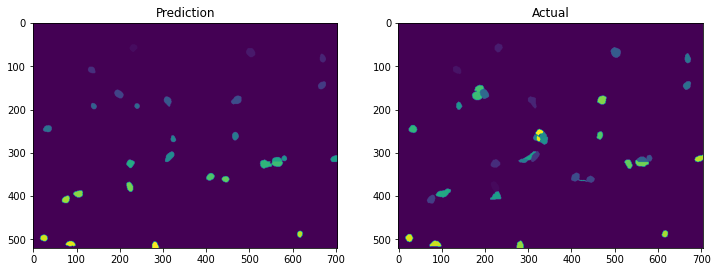

Thresh	TP	FP	FN	Prec.
0.500	28	1	10	0.718
0.550	28	1	10	0.718
0.600	26	3	12	0.634
0.650	26	3	12	0.634
0.700	25	4	13	0.595
0.750	22	7	16	0.489
0.800	15	14	23	0.288
0.850	3	26	35	0.047
0.900	1	28	37	0.015
0.950	0	29	38	0.000
AP	-	-	-	0.414


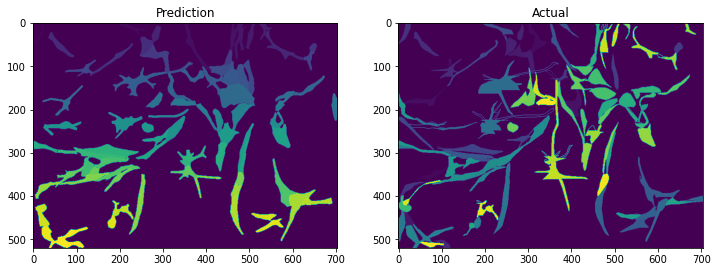

Thresh	TP	FP	FN	Prec.
0.500	60	24	39	0.488
0.550	55	29	44	0.430
0.600	46	38	53	0.336
0.650	36	48	63	0.245
0.700	26	58	73	0.166
0.750	16	68	83	0.096
0.800	6	78	93	0.034
0.850	1	83	98	0.005
0.900	0	84	99	0.000
0.950	0	84	99	0.000
AP	-	-	-	0.180


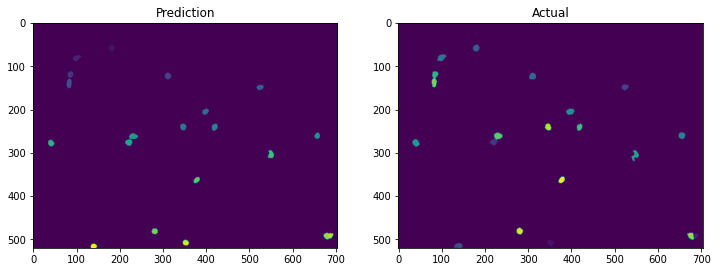

Thresh	TP	FP	FN	Prec.
0.500	20	0	0	1.000
0.550	20	0	0	1.000
0.600	20	0	0	1.000
0.650	20	0	0	1.000
0.700	18	2	2	0.818
0.750	18	2	2	0.818
0.800	12	8	8	0.429
0.850	6	14	14	0.176
0.900	1	19	19	0.026
0.950	0	20	20	0.000
AP	-	-	-	0.627


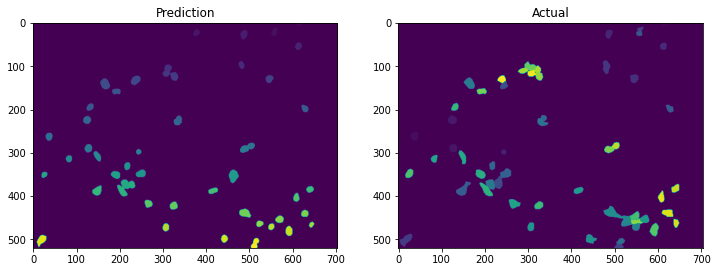

Thresh	TP	FP	FN	Prec.
0.500	46	5	11	0.742
0.550	43	8	14	0.662
0.600	40	11	17	0.588
0.650	37	14	20	0.521
0.700	33	18	24	0.440
0.750	26	25	31	0.317
0.800	19	32	38	0.213
0.850	9	42	48	0.091
0.900	4	47	53	0.038
0.950	0	51	57	0.000
AP	-	-	-	0.361
Final Score | 0.395439445789505


In [6]:
predictions = pd.read_csv("submission.csv")

predicted_ids = predictions["id"].unique().tolist()

scores = []
for image_id in predicted_ids:
    df_pred = predictions[predictions["id"] == image_id]
    df_id   = df[df["id"] == image_id]
                              
    cell_type = df_id["cell_type"].tolist()[0]
    
    actual_rle = df_id["annotation"].tolist()
    pred_rle   = df_pred["predicted"].tolist()
    
    pred_mask   = rle_decode(pred_rle)
    actual_mask = rle_decode(actual_rle)
    
    plot_pred_actual(pred_mask, actual_mask, show = True)
    
    score = iou_map([pred_mask], [actual_mask], verbose = True)    
    scores.append(score)
                                               
                  
print(f"Final Score | {np.mean(scores)}")    